In [1]:
from pathlib import Path 
import os
import yaml
from fundus_quality_prediction import FundusQualityModel, FundusQualityLoader, MODELS_DIR

### Train and/or evaluate a single model

Set the below as desired (TRAIN, ckpt, config)

In [2]:
TRAIN = True
ckpt = "" # To pass no checkpoint, use: "". Default is "".

## Datasets
## Note: When running for the first time, data will be copied to a local folder in the project directory.

# DrimDB dir should contain "Bad", "Good" and "Outliers" folders
drimdb_dir = "../../DrimDB/"
# DeepDRiD dir should contain "regular_fundus_images"
deepdrid_dir = "../../DeepDRiD/"

Then, run the below code to train and/or evaluate a single model. If you train a model, adjust the config below to as desired.

In [9]:
if TRAIN:
    config = {   
        "model_type": "efficientnet-b0", # Choose from efficientnet-b{0-7} or resnet{18,34,50,101,152}
        "epochs": 3, # Use 25 or more
        "img_size": 350, # Default: 350
        "lr": 1e-4, # Default: 1e-4
        "balance_datasets": True, # Oversample minority class(es) and downsample majority class(es). Default: True
        "seed": 12345, # For reproducibility. Default: 12345 
        "device": "cuda:0", # "cpu" or "cuda:<x>" where x is the GPU number. Default: "cuda:0"
        "weight_decay": 0.0, # Default: 0.0
        "use_datasets": [ 'drimdb', 'deepdrid-isbi2020' ], # "all" equals [ 'drimdb', 'deepdrid-isbi2020' ]
        "batch_size": 8 # Default: 8
        }
else:
    if ckpt == "" or ckpt is None:
        ckpt = sorted(os.listdir(MODELS_DIR))[-1]

    if not "models/" in ckpt:
        ckpt = MODELS_DIR / ckpt

    with open(ckpt / "config.yaml") as c:
        config = yaml.safe_load(c)

In [10]:
config

{'model_type': 'efficientnet-b0',
 'epochs': 3,
 'img_size': 350,
 'lr': 0.0001,
 'balance_datasets': True,
 'seed': 12345,
 'device': 'cuda:0',
 'weight_decay': 0.0,
 'use_datasets': ['drimdb', 'deepdrid-isbi2020'],
 'batch_size': 8}

In [11]:
model = FundusQualityModel(config)

In [14]:
train_dataloader, val_dataloader, test_dataloader = FundusQualityLoader(
    config, verbose=False, drimdb_dir=drimdb_dir, deepdrid_dir=deepdrid_dir
    ).get_dataloaders()

In [13]:
print(f"Lengths: {len(train_dataloader.dataset)}, {len(val_dataloader.dataset)}, {len(test_dataloader.dataset)}")

Lengths: 1329, 443, 444


Epoch: 1 Training...: 100%|██████████| 167/167 [00:30<00:00,  5.49it/s]
Epoch: 1, Train Loss: 0.4281, Val Loss: 0.5494, Train Acc: 0.7882, Val Acc: 0.7143: 100%|██████████| 56/56 [00:02<00:00, 20.29it/s]
Epoch: 2 Training...: 100%|██████████| 167/167 [00:24<00:00,  6.92it/s]
Epoch: 2, Train Loss: 0.3279, Val Loss: 0.5488, Train Acc: 0.8473, Val Acc: 0.7210: 100%|██████████| 56/56 [00:02<00:00, 21.14it/s]
Epoch: 3 Training...: 100%|██████████| 167/167 [00:24<00:00,  6.96it/s]
Epoch: 3, Train Loss: 0.3166, Val Loss: 0.5816, Train Acc: 0.8548, Val Acc: 0.7009: 100%|██████████| 56/56 [00:02<00:00, 21.84it/s]


Best epoch: 1, Best loss: 0.5488113193465064, Best acc: 0.7209821428571429



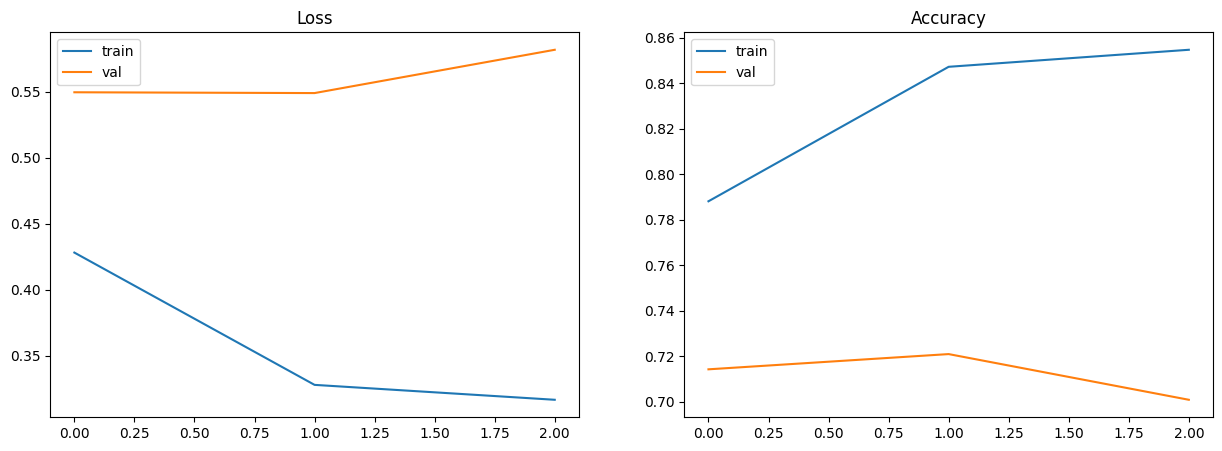

In [15]:
if TRAIN:
    model.train(train_dataloader, val_dataloader)

else:
    model.load_checkpoint(ckpt)

Evaluate on testset as specified in config

In [16]:
model.evaluate(test_dataloader=test_dataloader)

Model loaded from 2024-05-23 12-10-04


{'acc': 0.772522509098053,
 'auroc': 0.7715078348881165,
 'auprc': 0.8199725775276164}

In [17]:
# Save summary to <project>/models/<datetime>/
model.save_summary()

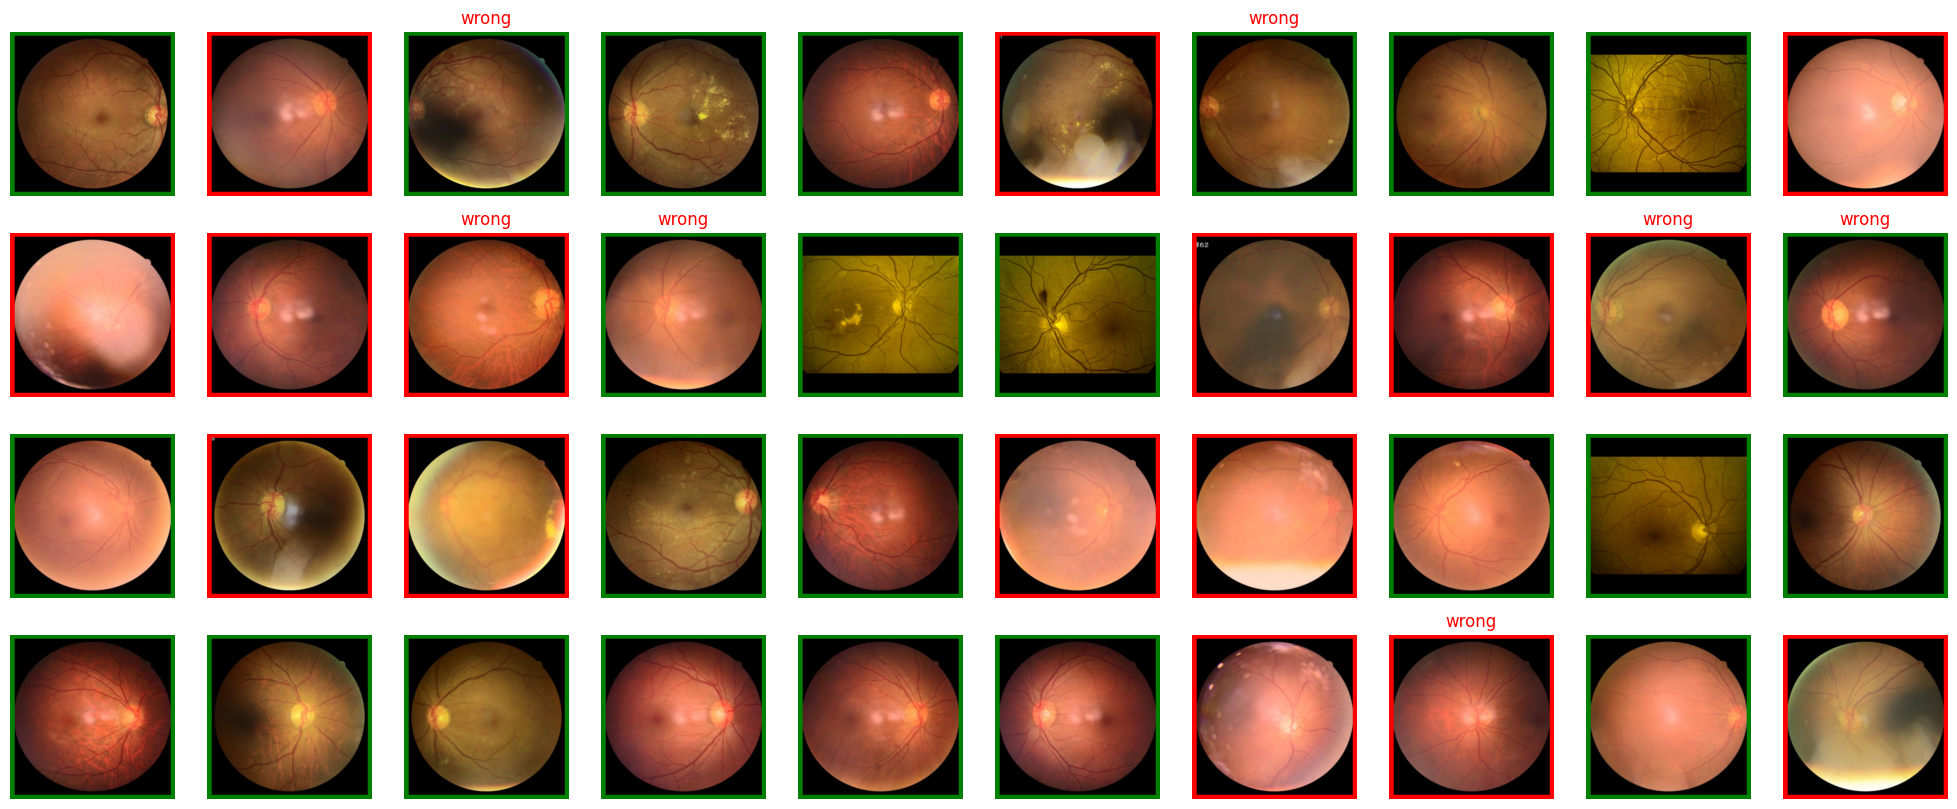

In [18]:
model.plot_grid(test_dataloader, size = 40, cols = 10)

Evaluate on a specific dataset origin only

In [19]:
dat = ["deepdrid-isbi2020"]

for ds in dat:
    config["use_datasets"] = [ds]
    _, _, test_dataloader = FundusQualityLoader(config, verbose=False).get_dataloaders()
    print(ds, model.evaluate(test_dataloader))
    model.save_summary(f"tested on test split of {ds}")

Model loaded from 2024-05-23 12-10-04
deepdrid-isbi2020 {'acc': 0.75, 'auroc': 0.7481934965877157, 'auprc': 0.7961716740706102}
